This notebook contains simillar information as notebook MFCC-ML in which all the operations were performed on training set. In this notebook, operations will be performed at an evaluation set, which contains more samples. I will also try to introduce manual dataset balancing.

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn import model_selection
from sklearn import linear_model
from sklearn.model_selection import KFold
from itertools import product
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [3]:
file_path = "MFCC_EVAL_FEATURES_LABELED.csv"


eval_df = pd.read_csv(file_path, delimiter=';')

# Drop the first row containing column numbers
eval_df.columns = eval_df.iloc[0]
eval_df = eval_df.drop(eval_df.index[0])

# Drop rows with NaN values
eval_df = eval_df.dropna()

# Drop the 'filename' column
eval_df = eval_df.drop(columns=['filename'])

# Transform 'spoof' to 0 and 'bonafide' to 1 in the 'Label' column
eval_df['Label'] = eval_df['Label'].map({'spoof': 0, 'bonafide': 1})

# Display the cleaned DataFrame
print(eval_df.head())



<ipython-input-3-a84e3181cccf>:4: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_df = pd.read_csv(file_path, delimiter=';')


0  Label      mfcc_1     mfcc_2      mfcc_3     mfcc_4      mfcc_5     mfcc_6  \
1      0    -205.015  139.56729   -46.88559    58.0535  -15.933013  6.7276654   
2      0   -285.1221  113.41989   -8.467953  40.317867   -16.11112  15.670601   
3      0   -232.6206  165.60791  -27.245367   49.38298    -2.76139  0.9697761   
4      0  -301.97018   69.38392  -44.413116  61.301666  -18.442436   -24.4736   
5      0  -317.13718  126.69181   -65.77651  22.715647  -28.936966  -8.015325   

0       mfcc_7      mfcc_8      mfcc_9  ...     mfcc_11     mfcc_12  \
1   -16.274055   -8.880779  -18.400627  ...  -5.2172213   -9.359123   
2    -8.908045   3.4256968  -21.877472  ...   -7.011489  -17.329466   
3  -0.86966246  -22.713154   -11.96604  ...   -9.854653  0.26017064   
4   -13.685907  -19.423687  -21.381638  ...   -8.331615  -2.3441758   
5   -23.152832  -25.740723   -21.53388  ...  -10.727237   -7.691421   

0     mfcc_13     mfcc_14    mfcc_15     mfcc_16     mfcc_17     mfcc_18  \
1   2.1554

In [4]:
# Separate features and labels
X = eval_df.drop(columns=["Label"])  # X contains features without columns Label and ID
Y = eval_df["Label"]  # y contains Labels (0 = Spoofed, 1 = Bonafide)

In [5]:
# Check class distribution
class_counts = pd.Series(Y).value_counts()
print("Class Distribution:\n", class_counts)

Class Distribution:
 Label
0    63882
1     7355
Name: count, dtype: int64


Create balanced dataset.

In [6]:
# Create a balanced DataFrame
bonafide_samples = eval_df[eval_df['Label'] == 1]
spoof_samples = eval_df[eval_df['Label'] == 0].sample(n=len(bonafide_samples), random_state=2141831)

balanced_df = pd.concat([bonafide_samples, spoof_samples]).reset_index(drop=True)

# Display the cleaned DataFrame
print(balanced_df.head())

0  Label      mfcc_1     mfcc_2      mfcc_3     mfcc_4      mfcc_5  \
0      1  -402.97076   91.89963  -0.2804517   9.626705   2.1565902   
1      1  -361.59763   98.52667  -10.046808   30.58372   1.0662949   
2      1   -339.0704  71.917534  -15.632757   42.56405  -6.0490546   
3      1   -285.8647  96.458115  -16.327173   35.89828  -12.864523   
4      1  -438.57904   80.79588   1.4521991  28.648617  -3.9705534   

0      mfcc_6       mfcc_7      mfcc_8      mfcc_9  ...     mfcc_11  \
0  0.74882054  -0.84038013  -0.8784534  -6.6335406  ...   -6.147995   
1   3.7170265   -7.6777797  -2.9077327   -5.661212  ...  -7.9528236   
2     4.45085   -11.570544  -2.0293078   -12.01788  ...   -9.456054   
3   1.9376915   -17.821392  -3.0684001  -10.632819  ...  -13.541451   
4   16.799059   -0.3702833    2.352389   -3.333776  ...   1.6654994   

0     mfcc_12     mfcc_13      mfcc_14     mfcc_15      mfcc_16     mfcc_17  \
0  -2.2708023   3.2372456    -4.231891  -2.7242274  -0.21906956  -0.62767

In [7]:
# Separate features and labels
X_bal = balanced_df.drop(columns=["Label"])  # X contains features without columns Label and ID
Y_bal = balanced_df["Label"]  # y contains Labels (0 = Spoofed, 1 = Bonafide)

In [8]:
# Check class distribution
class_counts = pd.Series(Y_bal).value_counts()
print("Class Distribution:\n", class_counts)

Class Distribution:
 Label
1    7355
0    7355
Name: count, dtype: int64


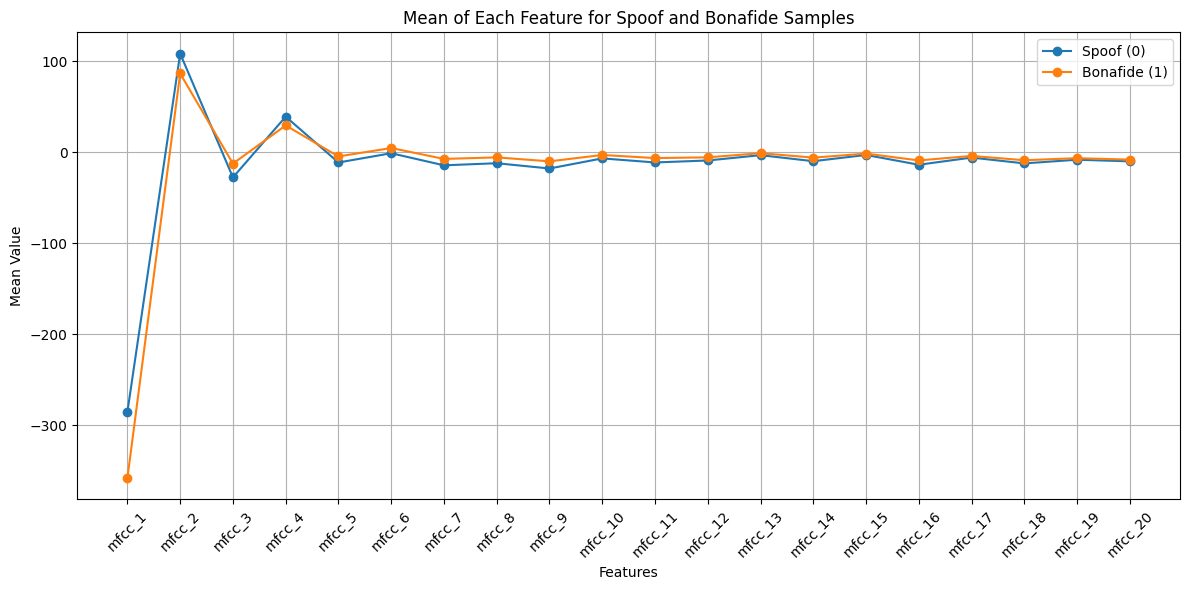

In [9]:
# Convert all feature columns to numeric, forcing errors to NaN
for col in balanced_df.columns:
    if col != "Label":
        balanced_df[col] = pd.to_numeric(balanced_df[col], errors='coerce')

# Calculate mean of each feature for both labels
mean_spoof = balanced_df[balanced_df['Label'] == 0].mean()
mean_bonafide = balanced_df[balanced_df['Label'] == 1].mean()

# Plot the means
plt.figure(figsize=(12, 6))
plt.plot(mean_spoof.index[1:], mean_spoof.values[1:], label='Spoof (0)', marker='o')
plt.plot(mean_bonafide.index[1:], mean_bonafide.values[1:], label='Bonafide (1)', marker='o')

plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.title('Mean of Each Feature for Spoof and Bonafide Samples')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X_bal, Y_bal, test_size = 0.2, random_state = 2141831)

print("Training size (Original):", X_train.shape[0])
print("Test size (Original):", X_test.shape[0])

Training size (Original): 11768
Test size (Original): 2942


In [11]:
clf = DecisionTreeClassifier(random_state=214831)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
roc_score = roc_auc_score(Y_test, Y_pred)

report = classification_report(Y_test, Y_pred)
print("Classification Report: \n", report)

Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.84      0.83      1455
           1       0.84      0.83      0.84      1487

    accuracy                           0.83      2942
   macro avg       0.83      0.83      0.83      2942
weighted avg       0.83      0.83      0.83      2942



In [12]:
rf = RandomForestClassifier(n_estimators=200, max_depth=100, random_state=2141831)
rf.fit(X_train, Y_train)

Y_pred = rf.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
class_report = classification_report(Y_test, Y_pred)

# Print evaluation metrics
print(f"Model Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Model Accuracy: 0.9079

Confusion Matrix:
 [[1273  182]
 [  89 1398]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.87      0.90      1455
           1       0.88      0.94      0.91      1487

    accuracy                           0.91      2942
   macro avg       0.91      0.91      0.91      2942
weighted avg       0.91      0.91      0.91      2942



In [13]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.2, random_state = 2141831)


In [14]:
# Train XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=100,  # Number of trees
    max_depth=6,  # Depth of each tree
    learning_rate=0.1,  # Step size shrinkage
    subsample=0.8,  # Percentage of samples used per tree
    colsample_bytree=0.8,  # Percentage of features used per tree
    random_state=2141831
)

xgb_model.fit(X_train, Y_train)

# Predictions on test set
Y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model performance
accuracy_xgb = accuracy_score(Y_test, Y_pred_xgb)
conf_matrix_xgb = confusion_matrix(Y_test, Y_pred_xgb)
class_report_xgb = classification_report(Y_test, Y_pred_xgb)

# Print model evaluation results
print(f"\nXGBoost Model Accuracy: {accuracy_xgb:.4f}")
print("\nConfusion Matrix:\n", conf_matrix_xgb)
print("\nClassification Report:\n", class_report_xgb)


XGBoost Model Accuracy: 0.9539

Confusion Matrix:
 [[12614   143]
 [  514   977]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     12757
           1       0.87      0.66      0.75      1491

    accuracy                           0.95     14248
   macro avg       0.92      0.82      0.86     14248
weighted avg       0.95      0.95      0.95     14248



<ipython-input-18-aed25f8707d8>:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  all_leading_digits_label_0 = label_0_data[mfcc_columns].applymap(first_non_zero_leading_digit).values.flatten()
<ipython-input-18-aed25f8707d8>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  all_leading_digits_label_1 = label_1_data[mfcc_columns].applymap(first_non_zero_leading_digit).values.flatten()


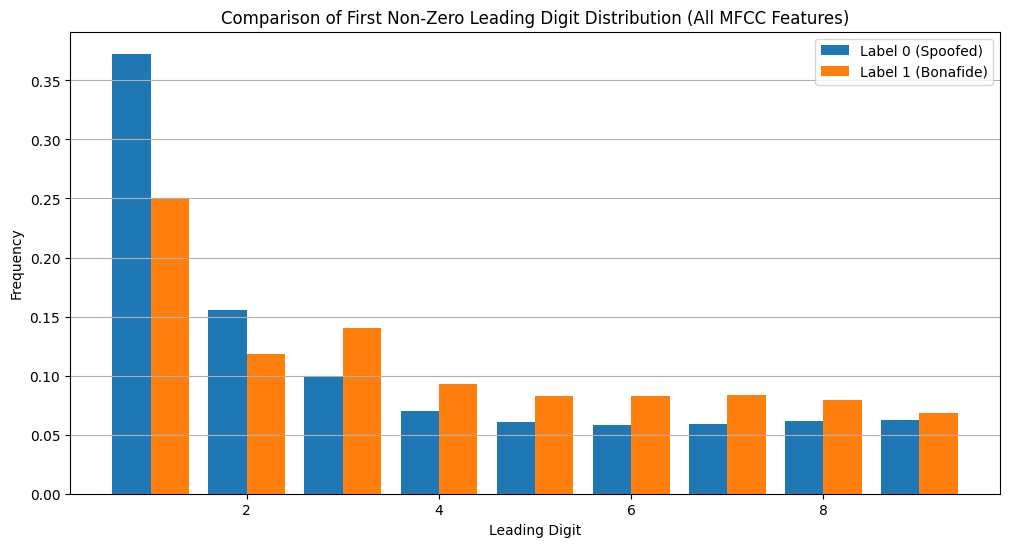

In [18]:
# Function to extract the first non-zero leading digit from a number
def first_non_zero_leading_digit(x):
    x = abs(float(x))
    if x == 0:
        return 0
    while x < 1:
        x *= 10
    return int(str(int(x)).lstrip('0')[0]) if str(int(x)).lstrip('0') else 0

# Select MFCC columns
mfcc_columns = [col for col in eval_df.columns if col.startswith('mfcc_')]

# Filter data for label 0 and label 1
label_0_data = eval_df[eval_df['Label'] == 0]
label_1_data = eval_df[eval_df['Label'] == 1]

# Combine all MFCC features into one series of leading digits
all_leading_digits_label_0 = label_0_data[mfcc_columns].applymap(first_non_zero_leading_digit).values.flatten()
all_leading_digits_label_1 = label_1_data[mfcc_columns].applymap(first_non_zero_leading_digit).values.flatten()

# Calculate frequency distribution of leading digits
combined_leading_digit_stats_label_0 = pd.Series(all_leading_digits_label_0).value_counts(normalize=True).sort_index()
combined_leading_digit_stats_label_1 = pd.Series(all_leading_digits_label_1).value_counts(normalize=True).sort_index()

# Plotting the combined leading digit statistics for both labels
plt.figure(figsize=(12, 6))
plt.bar(combined_leading_digit_stats_label_0.index - 0.2, combined_leading_digit_stats_label_0.values, width=0.4, label='Label 0 (Spoofed)')
plt.bar(combined_leading_digit_stats_label_1.index + 0.2, combined_leading_digit_stats_label_1.values, width=0.4, label='Label 1 (Bonafide)')

plt.title('Comparison of First Non-Zero Leading Digit Distribution (All MFCC Features)')
plt.xlabel('Leading Digit')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y')
plt.show()


In [19]:
# Train SVM Classifier with RBF kernel
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=2141831)
svm_model.fit(X_train, Y_train)

# Predictions on test set
Y_pred_svm = svm_model.predict(X_test)

# Evaluate model performance
accuracy_svm = accuracy_score(Y_test, Y_pred_svm)
conf_matrix_svm = confusion_matrix(Y_test, Y_pred_svm)
class_report_svm = classification_report(Y_test, Y_pred_svm)

# Print model evaluation results
print(f"\nSVM Model Accuracy: {accuracy_svm:.4f}")
print("\nConfusion Matrix:\n", conf_matrix_svm)
print("\nClassification Report:\n", class_report_svm)


SVM Model Accuracy: 0.9613

Confusion Matrix:
 [[12615   142]
 [  410  1081]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     12757
           1       0.88      0.73      0.80      1491

    accuracy                           0.96     14248
   macro avg       0.93      0.86      0.89     14248
weighted avg       0.96      0.96      0.96     14248



Deep learning stuff, WIP

In [22]:
# Load and preprocess evaluation dataset
file_path = "MFCC_EVAL_FEATURES_LABELED.csv"  # Ensure this path is correct
eval_df = pd.read_csv(file_path, delimiter=';')

# Drop the first row containing column names and NaN values
eval_df.columns = eval_df.iloc[0]
eval_df = eval_df.drop(eval_df.index[0])
eval_df = eval_df.dropna()

# Drop the 'filename' column and map labels
eval_df = eval_df.drop(columns=['filename'])
eval_df['Label'] = eval_df['Label'].map({'spoof': 0, 'bonafide': 1})


<ipython-input-22-37414a240410>:3: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_df = pd.read_csv(file_path, delimiter=';')


In [27]:
# Balance the dataset
bonafide_samples = eval_df[eval_df['Label'] == 1]
spoof_samples = eval_df[eval_df['Label'] == 0].sample(n=len(bonafide_samples), random_state=2141831)
balanced_df = pd.concat([bonafide_samples, spoof_samples]).reset_index(drop=True)

# Separate features and labels
X = balanced_df.drop(columns=["Label"]).values
Y = balanced_df["Label"].values

In [28]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape X for CNN (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)


In [29]:

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [30]:

# Build CNN Model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Binary classification
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Train the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7988 - auc: 0.8679 - loss: 0.4567 - val_accuracy: 0.8662 - val_auc: 0.9410 - val_loss: 0.3593
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8556 - auc: 0.9252 - loss: 0.3359 - val_accuracy: 0.8951 - val_auc: 0.9535 - val_loss: 0.2768
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8699 - auc: 0.9409 - loss: 0.3061 - val_accuracy: 0.9002 - val_auc: 0.9626 - val_loss: 0.2429
Epoch 4/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8768 - auc: 0.9447 - loss: 0.2955 - val_accuracy: 0.9061 - val_auc: 0.9638 - val_loss: 0.2376
Epoch 5/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8882 - auc: 0.9507 - loss: 0.2751 - val_accuracy: 0.9070 - val_auc: 0.9659 - val_loss: 0.2308
Epoch 6/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8900 - auc: 0.9556 - loss: 0.2644 - val_accuracy: 0.9133 - val_auc: 0.9685 - val_loss: 0.2258
Epoch 7/20
295/295 ━━━━━━━━━━━━━━━━━━━━

In [32]:

# Evaluate the model
loss, accuracy, auc = model.evaluate(X_test, Y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Test AUC: {auc:.4f}")


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9248 - auc: 0.9769 - loss: 0.1843
Test Loss: 0.1806, Test Accuracy: 0.9239, Test AUC: 0.9790


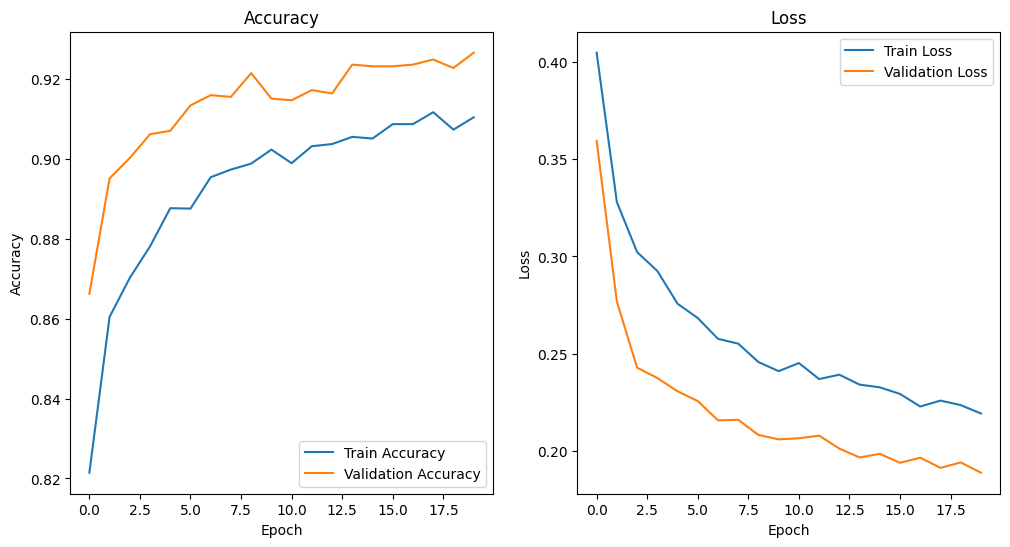

In [35]:
# Plot training and validation metrics

plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()